# Seperating Frequent Flyers from Non Frequent Flyers

This notebook contains an initial analysis of some basic data columns from our data files.

We tried to see the accuracy of finding the seperation between our two classes by use of:

- ETOH (alcohol consupmtion)
- Patient Smoking Profile 
- Diabates profile
- And finally, prescriptions (by mapping IS9/10 codes to related illnesses and conditions)

Multiple routines will compute vectors from the data columns, which are fed into our ML models, and error rate is printed out.

## Initialisation & setup

Reading our data from files and declaring data processing routines

In [1]:
%matplotlib inline
# notebook
import matplotlib.pylab as pylab
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.cluster import KMeans
from collections import Counter
import numpy as np
from sklearn.decomposition import PCA

#make the graphs bigger
pylab.rcParams['figure.figsize'] = (32.0, 24.0)
pylab.rcParams['font.size'] = 24

In [2]:
cohort = []
ETOH = []
hw = []
labOrders = []
medOrders = []
prescriptions = []
radiology = []
tobacco = []
vitals = []

In [3]:
def fileToList(fname):
    dataArray = []
    with open(fname) as f:
        for line in f:
            new = line.strip()
            new = new[1:len(new) - 1]
            new = new.split('","')
            if (len(new) > 1):
                dataArray.append(new)
    return dataArray

In [4]:
def fileToDict(fname):
    dataDict = dict()
    with open(fname) as f:
        for line in f:
            new = line.strip()
            new = new[1:len(new) - 1]
            new = new.split('","')
            if (len(new) > 1):
                if not(new[0] in dataDict):
                    dataDict[new[0]] = [new]
                else:
                    dataDict[new[0]].append(new)
    return dataDict

In [5]:
fname = "2018-4169_Cohort.txt"
cohort = fileToList(fname)

fname = "2018-4169_ETOH_Use.txt"
ETOH = fileToDict(fname)

fname = "2018-4169_Height_Weight.txt"
hw = fileToDict(fname)

fname = "2018-4169_Lab_Orders_Performed.txt"
labOrders = fileToDict(fname)


In [6]:
fname = "2018-4169_Med_Orders.txt"
medOrders = fileToDict(fname)

fname = "2018-4169_Prescriptions.txt"
prescriptions = fileToList(fname)

In [7]:
fname = "2018-4169_Tobacco_Use.txt"
tobacco = fileToDict(fname)

In [8]:
fname = "2018-4169_ETOH_Use.txt"
ETOHList = fileToList(fname)

In [9]:
tobList = fileToList(fname)

In [10]:
#organises data into a dict of dict of lists
#dict of years
    #dict of patients
        #entry of admissions
def organiseCohortDataIndex(myCohort):
    organised = dict()
    for admission in myCohort:
        year = admission[8][0:4]
        if year in organised:
            entry = organised[year]
            if admission[0] in entry:
                organised[year][admission[0]].append(admission[1:])
            else:
                organised[year][admission[0]] = [admission[1:]]
        else:
            patientData = dict()
            patientData[admission[0]] = [admission[1:]]
            organised[year] = patientData
    return organised

#gets non frequent flyers from the organised cohort dict above
def getNonFrequentFlyersBase(cohortDict, frequentFlyerDict):
    regular = dict()
    for year in cohortDict:
        regular[year] = dict()
        patList = cohortDict[year]
        for pKey in patList:
            if not(pKey in frequentFlyerDict[year]):
                regular[year][pKey] = cohortDict[year][pKey]
    return regular

#gets frequent flyers from the organised cohort dict above (defined by greater than or equal to a specified visit num)
def getFrequentFlyersExtended(dataDict, year=None, visits=10):
    if (year == None):
        freqDict = dict()
        for key in dataDict:
            freqDict[key] = []
            patientDict = dataDict[key]
            for pKey in patientDict:
                if len(patientDict[pKey]) >= visits:
                    freqDict[key].append(pKey)
        return freqDict
    else:
        freqDict= dict()
        if (year in dataDict):
            patientDict = dataDict[year]
            for pKey in patientDict:
                if len(patientDict[pKey]) >= visits:
                    freqDict[key].append(pKey)
            return freqDict
        else:
            return dict()

In [11]:
import collections
from datetime import datetime

#returns a dict of lists
    #dict of patients
        #list of admissions
def organiseCohortData(myCohort):
    organised = dict()
    for admission in myCohort:
        if admission[0] in organised:
            organised[admission[0]].append(admission[1:])
        else:
            organised[admission[0]] = [admission[1:]]
            
    
    for p in organised.keys():
        organised[p] = sorted(organised[p], key = lambda x: datetime.strptime(x[8][0:10], '%Y-%m-%d'))
    return organised
    

In [12]:
organised = organiseCohortData(cohort[1:])

In [13]:
from datetime import datetime, timedelta

#method for finding frequent flyers where you specify a gap/time frame in days(e.g. 12 months, one month, one week etc)
#and a number of visits, and this method will get frequent flyers for that definition
#uses the organisation of the cohort data specified by the organiseCohortData method (aka dict of lists)
def abstractFreqFlyers(organised, gap, visits):
    frequentFlyers = []
    for p in organised.keys():
        dates = [datetime.strptime(item[8][0:10], '%Y-%m-%d') for item in organised[p]]
        try:
            for i in range(len(dates)):
                modified_date = dates[i] + timedelta(days=gap)
                if dates[i+visits-1] <= modified_date:
                    frequentFlyers.append(p)
                    break
        except:
            pass
    return frequentFlyers

In [14]:
frequents = abstractFreqFlyers(organised, 365,20) #as a test, this calculates frequent flyers that, in the space of a year, have made 10 visits

In [15]:
# print how many frequent flyers we got
print(len(frequents))

126


In [16]:
# the id's of the test frequent flyers 
print(frequents[0:5])

['0.54629537974305198', '0.18454035455437792', '0.49137990165585754', '0.31499293513474674', '7.0830591556572897E-2']


In [17]:
#def difference(l1,l2):
    #precisionError = len([b for a,b in zip(l1,l2) if b != a and b == 0 and a == 1])
    #recallError = len([b for a,b in zip(l1,l2) if b != a and b == 1 and a == 0])
    #print("Precision Error is " + str(precisionError))
    #print("Recall Error is " + str(recallError))
    #return (precisionError) + (recallError)
    
def difference(l1,l2):
    return len([b for a,b in zip(l1,l2) if b != a])  

In [18]:
#given a set of data training points (Xtr) and classes (patientBase), run a number of models 
#use a K-fold algorithm to get error across 4 runs overall
def runModels(Xtr, patientBase):
    kf = KFold(n_splits=5, shuffle=True)
    Ytr = patientBase
    differencesLR = []
    differencesSVM = []
    differencesKM = []

    for train_index, test_index in kf.split(Xtr):
        X_train, X_test = [Xtr[i] for i in train_index], [Xtr[i] for i in test_index]
        y_train, y_test = [Ytr[i] for i in train_index], [Ytr[i] for i in test_index]
    
        if (1 in y_train and 0 in y_train):
            lr = LogisticRegression()
            lr.fit(X_train, y_train)
            PredLR = lr.predict(X_test)
            differencesLR.append(difference(PredLR, y_test)/len(y_test))
    
            km = KMeans(n_clusters=2)
            km.fit(X_train, y_train)
            PredKM = km.predict(X_test)
            differencesKM.append(difference(PredKM, y_test)/len(y_test))

            clf = svm.SVC()
            clf.fit(X_train, y_train)
            PredSVM = clf.predict(X_test)
            differencesSVM.append(difference(PredSVM, y_test)/len(y_test))
    print((differencesLR))
    print((differencesSVM))
    print((differencesKM))

In [19]:
# IS9 and IS10 codes
# show the main reasons for entry to the hospital
def getIndexIS9(code):
    if code >= 0 and code < 140: return 0
    if code >= 140 and code < 240: return 1
    if code >= 240 and code < 280: return 3
    if code >= 280 and code < 290: return 2
    if code >= 290 and code < 320: return 4
    if code >= 320 and code < 390: return 5
    if code >= 390 and code < 460: return 6
    if code >= 460 and code < 520: return 7
    if code >= 520 and code < 580: return 8
    if code >= 580 and code < 630: return 15
    if code >= 630 and code < 680: return 10
    if code >= 680 and code < 710: return 11
    if code >= 710 and code < 740: return 9
    if code >= 740 and code < 760: return 12
    if code >= 760 and code < 780: return 13
    if code >= 800 and code < 1000: return 14

def getIndexIS10(code):
    if ((code[0]).lower() == 'a' or (code[0]).lower() == 'b'): return 0
    if ((code[0]).lower() == 'c' or ((code[0]).lower() == 'd' and int(code[1]) < 5)): return 1
    if ((code[0]).lower() == 'd'): return 2
    if ((code[0]).lower() == 'e'): return 3
    if ((code[0]).lower() == 'f'): return 4
    if ((code[0]).lower() == 'g'): return 5
    if ((code[0]).lower() == 'i'): return 6
    if ((code[0]).lower() == 'j'): return 7
    if ((code[0]).lower() == 'k'): return 8
    if ((code[0]).lower() == 'm'): return 9
    if ((code[0]).lower() == 'o'): return 10
    if ((code[0]).lower() == 'l'): return 11
    if ((code[0]).lower() == 'q'): return 12
    if ((code[0]).lower() == 'p'): return 13
    if ((code[0]).lower() == 's' or (code[0]).lower() == 't'): return 14
    if ((code[0]).lower() == 'n'): return 15

def getFeatures(datalist):
    datalist = organised[datalist]
    codes = [item[10] for item in datalist]
    #[infections,neoplasms,blood,metabolic,mental,nervous,circulatory,respiratory,digestive,muskoskeletal,pregnancy,skin,congenital,perinatal,poison, genitourinary]
    features = [0] * 16
    for code in codes:
        if (len(code)>0):
            try:
                newcode = float(code)
                features[getIndexIS9(newcode)] = 1
            except:
                if(getIndexIS10(code) is not None): features[getIndexIS10(code)] = 1
    return features

In [20]:
#given a sentence, is the patient a serious smoker
def isBadSmoking(res):
    if (res == "current every day smoker" or res == "current some day smoker" or res == "current every day" or res=="heavy tobacco smoker"):
        return 1
    else:
        return 0
    
#given a sentence, is the patient a big drinker
def isBad(cat,res):
    if (cat == "Number of Standard Drinks on a Typical Day"):
        if (res == "10 or more" or res == "7 to 9"):
            return 1
        else:
            return 0
    elif (cat == "Alcohol Treatment Offered"):
        if (res == "yes"):
            return 1
        else:
            return 0
    elif (cat == "Excessive Alcohol and Drug Use"):
        if (res == "yes"):
            return 1
        else:
            return 0
    elif (cat == "10.Has a Relative, Friend, Doctor, or Other Health Professional Expressed Concern About Your Drinking or Suggested You Cut Down"):
        if (res == "(2) Yes, during the last year"):
            return 1
        else:
            return 0
    
    return 0

#given a list of frequent flyer ids, return 3 lists: 
#first list = list of 1s the size of frequents (= list of classes for our model)
#list of 1s and 0s corresponding to whether the patient drinks a lot of alcohol (ETOH results)
#list of 1s and 0s corresponding to whether the patient smokes a lot (tobacco results)

def frequentsArray(frequents, value):
    smokesHeavyFreqs = []
    ETOHHeavyFreqs = []
    patientBase = []
    
    for p in frequents:
        patientBase.append(value)
        if p in ETOH:
            entry = ETOH[p]
            drinkFreq = isBad(entry[0][4], entry[0][5])
            ETOHHeavyFreqs.append(drinkFreq)
        else:
            ETOHHeavyFreqs.append((value-1)*-1)
        if p in tobacco:
            entry = tobacco[p]
            smokingFreq = isBadSmoking(entry[0][2])
            smokesHeavyFreqs.append(smokingFreq)
        else:
            smokesHeavyFreqs.append(0)
                
    return (patientBase, ETOHHeavyFreqs, smokesHeavyFreqs)

In [21]:
#given a list of ids, returns a list where it is 1 if patient is diabetic, and 0 if not
def getDiabetes(deIds):
    diabetes = []
    for patient in deIds:
        if patient in organised:
            entry = organised[patient][0]
            if (entry[-1] == "Diabetes"):
                diabetes.append(1)
            else:
                diabetes.append(0)
    return diabetes

In [22]:
#calculates Xtr and Ytr and runs models 
def runCode(frequents, regs):
    
    freqFeatures = list(map(getFeatures, frequents))
    regFeatures = list(map(getFeatures, regs))

    Xtr = freqFeatures+regFeatures
    Ytr = [1]*len(freqFeatures) + [0]*len(regFeatures)
    print("---------------------------------------------------")
    print("Using Labels")
    runModels(Xtr,Ytr)
    print("---------------------------------------------------")
    
    patBase1, ETOHHeavyFreqs, smokesHeavyFreqs = frequentsArray(frequents, 1)
    patBase2, ETOHHeavyRegs, smokesHeavyRegs = frequentsArray(regs, 0)

    patientBase = patBase1 + patBase2
    totalSmokes = smokesHeavyFreqs + smokesHeavyRegs
    ETOHTotal = ETOHHeavyFreqs + ETOHHeavyRegs
    DiabetesTotal = getDiabetes(frequents) + getDiabetes(regs)
    PrescriptionsTotal = prescIndicators(frequents) + prescIndicators(regs)

    Xtr = list(map(list,zip(totalSmokes, ETOHTotal)))
    print("Models on ETOH and Tobacco")
    runModels(Xtr, patientBase)
    print("----------------------")
    print("Models on ETOH, Tobacco and Diabetes")
    Xtr = list(map(list,zip(totalSmokes, ETOHTotal, DiabetesTotal)))
    runModels(Xtr, patientBase)
    print("----------------------")
    print("Models on ETOH, Tobacco, Diabetes and Prescriptions")
    Xtr = list(map(list,zip(totalSmokes, ETOHTotal, DiabetesTotal, PrescriptionsTotal)))
    runModels(Xtr, patientBase)
    print("----------------------")
    print("Models on Prescriptions")
    Xtr = list(map(list,zip(PrescriptionsTotal)))
    runModels(Xtr, patientBase)

In [23]:
#same as above but this time, the frequents and regs parameters are dicts (extra dimension of year), not lists
def runCodeDicts(frequents, regs):
    patBase1, ETOHHeavyFreqs, smokesHeavyFreqs = frequentsArrayOrg(frequentsBase)
    patBase2, ETOHHeavyRegs, smokesHeavyRegs = regsArrayOrg(regularsBase)

    patientBase = patBase1 + patBase2
    totalSmokes = smokesHeavyFreqs + smokesHeavyRegs
    ETOHTotal = ETOHHeavyFreqs + ETOHHeavyRegs
    
    listFreqs = []
    for f in frequents.keys():
        listFreqs = listFreqs + frequents[f]

    listFreqs = list(set(listFreqs))
    DiabetesTotal = getDiabetes(listFreqs) + getDiabetes(regs)
    PrescriptionsTotal = prescIndicators(listFreqs) + prescIndicators(regs)

    Xtr = list(map(list,zip(totalSmokes, ETOHTotal)))
    print("Models on ETOH and Tobacco")
    runModels(Xtr, patientBase)
    print("----------------------")
    print("Models on ETOH, Tobacco and Diabetes")
    Xtr = list(map(list,zip(totalSmokes, ETOHTotal, DiabetesTotal)))
    runModels(Xtr, patientBase)
    print("----------------------")
    print("Models on ETOH, Tobacco, Diabetes and Prescriptions")
    Xtr = list(map(list,zip(totalSmokes, ETOHTotal, DiabetesTotal, PrescriptionsTotal)))
    runModels(Xtr, patientBase)
    print("----------------------")
    print("Models on ETOH, Tobacco, Diabetes and Prescriptions")
    Xtr = list(map(list,zip(PrescriptionsTotal)))
    runModels(Xtr, patientBase)

In [24]:
from collections import Counter

names = [item[3] for item in prescriptions]
organisedPrescriptions = fileToDict("2018-4169_Prescriptions.txt")
ordered = Counter(names[1:])
orderedPrescList = list(ordered.keys())

In [25]:
def retrieveRegulars(org, frequents):
    regularsBase = []
    newOrder = Counter(frequents)
    for k in org.keys():
        if not(k in newOrder):
            regularsBase.append(k)
    
    return list(np.random.choice(regularsBase, len(frequents)))

In [26]:
from datetime import datetime, timedelta
import math

def stayLength(entry):
    enterTime = datetime.strptime(entry[8][:19], '%Y-%m-%d %H:%M:%S')
    leaveTime = datetime.strptime(entry[9][:19], '%Y-%m-%d %H:%M:%S')
    
    return abs(((leaveTime - enterTime).total_seconds() / 60.0) / 60.0)

hours = list(map(stayLength, cohort[1:]))
print(hours[0:100])
                      

[28.83555555555556, 3.078611111111111, 13.217777777777778, 5.9525, 9.353611111111112, 4.726388888888889, 6.105555555555555, 9.41111111111111, 45.94444444444444, 7.835277777777778, 5.109166666666667, 2.7308333333333334, 2.428611111111111, 1.2408333333333335, 4.418333333333334, 7.297777777777778, 35.82805555555556, 20.513055555555557, 10.508333333333333, 9.239444444444445, 3.523611111111111, 7.451944444444445, 1.383888888888889, 16.54888888888889, 6.224166666666666, 8.409444444444444, 6.086388888888889, 1.6197222222222223, 1.4372222222222222, 3.411388888888889, 16.42361111111111, 6.875555555555556, 46.95111111111111, 6.893888888888889, 4.148055555555556, 6.035277777777778, 7.266666666666667, 2.6191666666666666, 7.953888888888889, 7.304166666666666, 103.7, 8.956666666666667, 2.111666666666667, 21.265555555555558, 0.9713888888888889, 23.214722222222225, 3.631111111111111, 1.5080555555555555, 10.999722222222223, 4.703055555555555, 2.3405555555555555, 6.599444444444444, 3.8316666666666666, 4

In [27]:
print(stayLength(cohort[112]))
print(cohort[112])

264.68
['0.74048663132949577', '0.12938483365496911', '54', 'Female', 'White', 'Hispanic or Latino', 'Spanish', 'ABDOMINAL PAIN', '2013-08-28 15:50:48.743000000', '2013-08-17 15:10:00', 'Home Routine', '590.80', 'Pyelonephritis, unspecified', 'SELF PAY', 'SELF PAY NOT SCREENED', '', '']


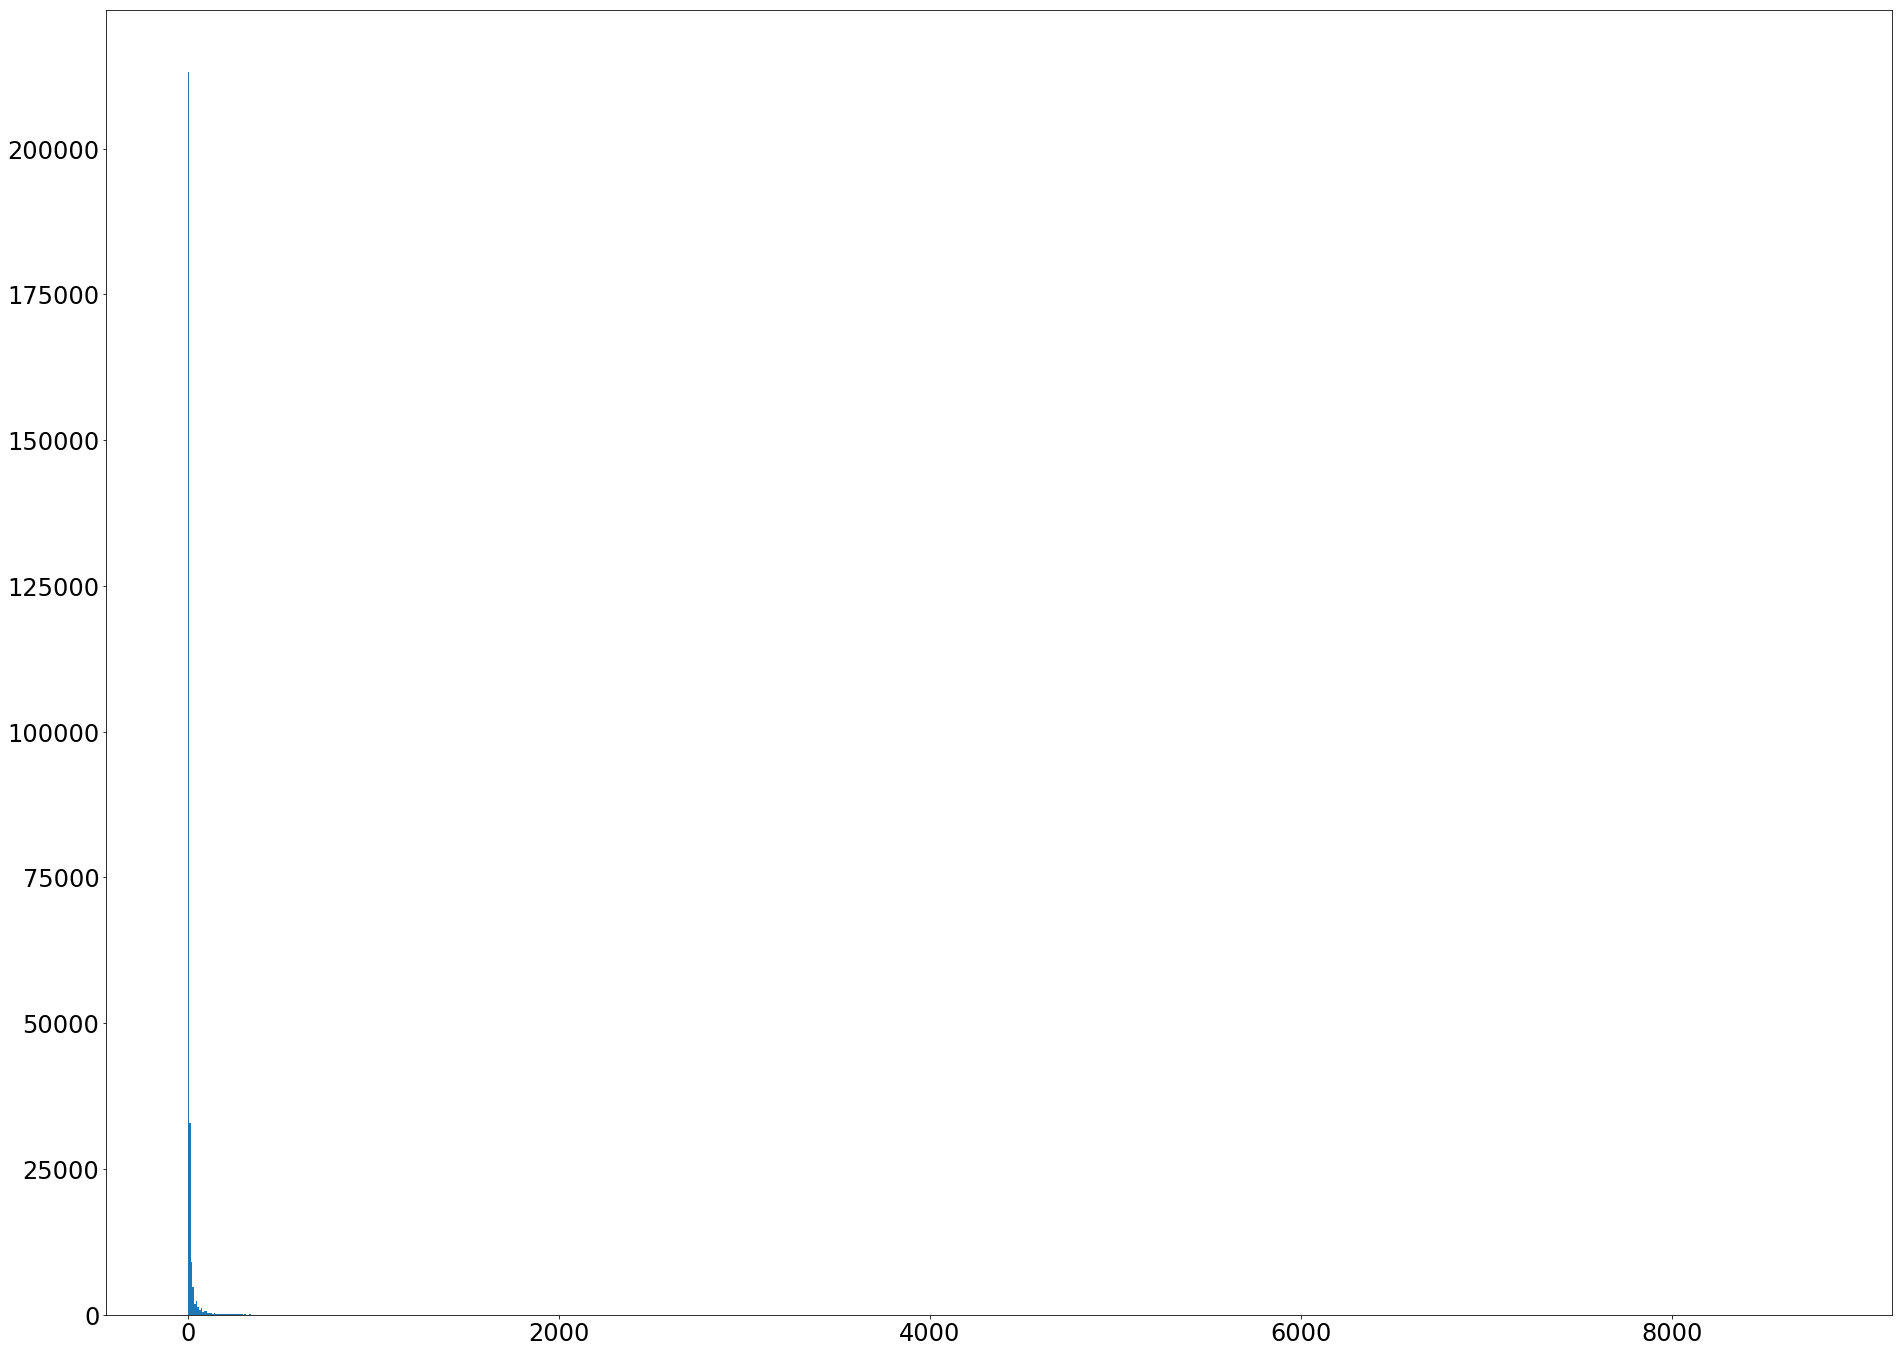

In [28]:
plt.hist(hours, bins=1000)
plt.show()

In [29]:
organised = organiseCohortData(cohort[1:])

freqs = abstractFreqFlyers(organised, 365, 5)
regs = retrieveRegulars(organised, freqs)

frequentHoursAll = [stayLength(k) for k in cohort[1:] if k[0] in freqs]
regsHoursAll = [stayLength(k) for k in cohort[1:] if k[0] not in freqs]

In [30]:

print(len(frequentHoursAll))
print(len(regsHoursAll))

57103
215973


In [31]:
frequentHours = np.random.choice(frequentHoursAll, 40000)
regsHours = np.random.choice(regsHoursAll, 40000)

print(len(frequentHours))
print(len(regsHours))

40000
40000


In [32]:
print(np.mean(frequentHours))
print(np.mean(regsHours))

14.4012134097
10.5872503333


In [33]:
Yte = [1]*len(frequentHours)+[0]*len(regsHours)
Ytr = np.concatenate((frequentHours,regsHours))

lr = LogisticRegression()
lr.fit(np.reshape(Ytr, (-1,1)), np.reshape(Yte, (-1,1)))
#print(lr.predict([[12]]))

print(lr.score(np.reshape(frequentHoursAll, (-1,1)), [1]*len(frequentHoursAll)))
print(lr.score(np.reshape(regsHoursAll, (-1,1)), [0]*len(regsHoursAll)))


C:\Users\davie\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.171549655885
0.869844841716


In [34]:
def runPrescriptions(frequents, regs, top=orderedPrescList[0:20]):
    
    medList = []
    for med in top:
        counter = 0
        for f in frequents:
            if (f in organisedPrescriptions):
                if (med in [item[3] for item in organisedPrescriptions[f]]):
                    counter = counter + 1
        medList.append(counter)
    
    medList2 = []
    for med in top:
        counter = 0
        for f in regs:
            if (f in organisedPrescriptions):
                if (med in [item[3] for item in organisedPrescriptions[f]]):
                    counter = counter + 1
        medList2.append(counter)
    
    x = ([(item / len(frequents)) for item in medList])
    y = ([(item / len(regs)) for item in medList2])

    x1 = np.array(x)
    y1 = np.array(y)

    return(x1 > y1, x, y)

In [35]:
indicatorIndices = [2, 8, 16, 19]
indicators = [orderedPrescList[k] for k in indicatorIndices]
print(indicators)

['citalopram', 'chlordiazePOXIDE', 'QUEtiapine', 'mirtazapine']


In [36]:
def prescIndicators(deIds):
    prescs = []
    for patient in deIds:
        if patient in organisedPrescriptions:
            entry = organisedPrescriptions[patient]
            data = [item[3] for item in entry]
            if (not set(data).isdisjoint(indicators)):
                prescs.append(1)
            else:
                prescs.append(0)
    return prescs

# Application of routines to our varying defintion of frequent flyers 

# N or more during indexed year

Follwing code blocks deal with the case where the definion of a frequent flyer is N visits per index year (2018, 1017, 2016 etc)

In [37]:
#specialised routines that get the ETOH,tobacco, and patientBase lists for dict base data 
#(aka is same as frequentsAray above, but works on dicts)
def frequentsArrayOrg(frequents):
    patListFreqs = []
    smokesHeavyFreqs = []
    ETOHHeavyFreqs = []
    patientBase = []
    
    for k in frequents.keys():
        patListFreqs = patListFreqs + frequents[k]
        for p in patListFreqs:
            patientBase.append(1)
            if p in ETOH:
                entry = ETOH[p]
                drinkFreq = isBad(entry[0][4], entry[0][5])
                ETOHHeavyFreqs.append(drinkFreq)
            else:
                ETOHHeavyFreqs.append(0)
            
            if p in tobacco:
                entry = tobacco[p]
                smokingFreq = isBadSmoking(entry[0][2])
                smokesHeavyFreqs.append(smokingFreq)
            else:
                smokesHeavyFreqs.append(0)
    return (patientBase, ETOHHeavyFreqs, smokesHeavyFreqs)

def regsArrayOrg(regulars):
    patListRegs = []
    smokesHeavyRegs = []
    ETOHHeavyRegs = []
    patientBase = []

    for k in regulars.keys():
        patListRegs = patListRegs + list(regulars[k].keys())

    for p in patListRegs:
        patientBase.append(0)

        if p in ETOH:
            entry = ETOH[p]
            drinkFreq = isBad(entry[0][4], entry[0][5])
            ETOHHeavyRegs.append(drinkFreq)
        else:
            ETOHHeavyRegs.append(0)
        
        if p in tobacco:
            entry = tobacco[p]
            smokingFreq = isBadSmoking(entry[0][2])
            smokesHeavyRegs.append(smokingFreq)
        else:
            smokesHeavyRegs.append(0)
    
    return (patientBase, ETOHHeavyRegs, smokesHeavyRegs)

In [38]:
organisedIndex = organiseCohortDataIndex(cohort[1:])

In [39]:
frequentsBase = getFrequentFlyersExtended(organisedIndex, visits=4)
regularsBase = getNonFrequentFlyersBase(organisedIndex, frequentsBase)
runCodeDicts(frequentsBase, regularsBase)

Models on ETOH and Tobacco
[0.14296593741345887, 0.14965845102926245, 0.14626941450693498, 0.14509242805381828, 0.1450231935565761]
[0.14296593741345887, 0.14965845102926245, 0.14626941450693498, 0.14509242805381828, 0.1450231935565761]
[0.7566002030831718, 0.24247669159051047, 0.24250536567353626, 0.24319771064595785, 0.24342849230343172]
----------------------
Models on ETOH, Tobacco and Diabetes
[]
[]
[]
----------------------
Models on ETOH, Tobacco, Diabetes and Prescriptions
[]
[]
[]
----------------------
Models on ETOH, Tobacco, Diabetes and Prescriptions
[]
[]
[]


In [40]:
listFreqs = []
for f in frequentsBase.keys():
    listFreqs = listFreqs + frequentsBase[f]
print(runPrescriptions(frequentsBase, regularsBase))
print(runPrescriptions(frequentsBase, regularsBase, indicators))

(array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False], dtype=bool), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
(array([False, False, False, False], dtype=bool), [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0])


# N visits 2 years after initial visit

Deals with the definiton of frequent flyers that defines a frequent flyer as returning N times within a space of 2 years after a given visit

In [41]:
organised = organiseCohortData(cohort[1:])

In [42]:
freqs = abstractFreqFlyers(organised, 730, 10)
regs = retrieveRegulars(organised, freqs)

runCode(freqs, regs)
print(runPrescriptions(freqs, regs))
print(runPrescriptions(freqs, regs, indicators))

---------------------------------------------------
Using Labels
[0.07705779334500876, 0.07705779334500876, 0.07543859649122807, 0.10350877192982456, 0.07192982456140351]
[0.08056042031523643, 0.07180385288966724, 0.06666666666666667, 0.10701754385964912, 0.06491228070175438]
[0.11733800350262696, 0.8651488616462347, 0.13333333333333333, 0.8473684210526315, 0.14035087719298245]
---------------------------------------------------
Models on ETOH and Tobacco
[0.050788091068301226, 0.06129597197898424, 0.05087719298245614, 0.05964912280701754, 0.05964912280701754]
[0.050788091068301226, 0.06129597197898424, 0.05087719298245614, 0.05964912280701754, 0.05964912280701754]
[0.9492119089316988, 0.9387040280210157, 0.9491228070175438, 0.05964912280701754, 0.05964912280701754]
----------------------
Models on ETOH, Tobacco and Diabetes
[0.06129597197898424, 0.0542907180385289, 0.056140350877192984, 0.04736842105263158, 0.06315789473684211]
[0.06129597197898424, 0.0542907180385289, 0.0561403508771

# N visits in 12 months

Deals with the definition that specifies a frequent flyer as visiting N times in the space of 12 months

In [43]:
organised = organiseCohortData(cohort[1:])

In [44]:
# N=3
freqs = abstractFreqFlyers(organised, 365, 3)
regs = retrieveRegulars(organised, freqs)

runCode(freqs, regs)
print(runPrescriptions(freqs, regs))
print(runPrescriptions(freqs, regs, indicators))

---------------------------------------------------
Using Labels
[0.14607843137254903, 0.15656152966170944, 0.15509070109495016, 0.15018793920575257, 0.15312959633927112]
[0.14607843137254903, 0.15656152966170944, 0.15509070109495016, 0.15018793920575257, 0.15312959633927112]
[0.55, 0.5448602712861579, 0.44255597319823503, 0.5463310998529172, 0.44925641444680503]
---------------------------------------------------
Models on ETOH and Tobacco
[0.04330065359477124, 0.048047066514136295, 0.04706651413629678, 0.04984474587350874, 0.04363458081385847]
[0.04330065359477124, 0.048047066514136295, 0.04706651413629678, 0.04984474587350874, 0.04363458081385847]
[0.9566993464052288, 0.048047066514136295, 0.04706651413629678, 0.04984474587350874, 0.9563654191861415]
----------------------
Models on ETOH, Tobacco and Diabetes
[0.04477124183006536, 0.04870076809936264, 0.050498447458735087, 0.04183690145448603, 0.046085961758457264]
[0.04477124183006536, 0.04870076809936264, 0.050498447458735087, 0.0

In [45]:
# N=4
freqs = abstractFreqFlyers(organised, 365, 4)
regs = retrieveRegulars(organised, freqs)

runCode(freqs, regs)
print(runPrescriptions(freqs, regs))
print(runPrescriptions(freqs, regs, indicators))

---------------------------------------------------
Using Labels
[0.1214574898785425, 0.1242603550295858, 0.11958891311118032, 0.13360323886639677, 0.1252336448598131]
[0.11896605418872626, 0.11211460604173155, 0.11709747742136406, 0.12488321395203986, 0.12305295950155763]
[0.4163811896605419, 0.4166926191217689, 0.573030208657739, 0.4238554967299907, 0.4264797507788162]
---------------------------------------------------
Models on ETOH and Tobacco
[0.05418872625350358, 0.047337278106508875, 0.05636873248209281, 0.05076300218000623, 0.056074766355140186]
[0.05418872625350358, 0.047337278106508875, 0.05636873248209281, 0.05076300218000623, 0.056074766355140186]
[0.9458112737464964, 0.047337278106508875, 0.9436312675179072, 0.9492369978199938, 0.056074766355140186]
----------------------
Models on ETOH, Tobacco and Diabetes
[0.050451572718779196, 0.05636873248209281, 0.052943008408595456, 0.04796013702896294, 0.05700934579439252]
[0.050451572718779196, 0.05636873248209281, 0.052943008408

In [46]:
# N=5
freqs = abstractFreqFlyers(organised, 365, 5)
regs = retrieveRegulars(organised, freqs)

runCode(freqs, regs)
print(runPrescriptions(freqs, regs))
print(runPrescriptions(freqs, regs, indicators))

---------------------------------------------------
Using Labels
[0.11491317671092952, 0.09964230965763925, 0.11854879918242207, 0.11497189575881452, 0.1195707715891671]
[0.10674157303370786, 0.10219724067450178, 0.11599386816555952, 0.11241696474195197, 0.10679611650485436]
[0.19816138917262513, 0.6131834440470108, 0.5794583546244252, 0.4113438937148697, 0.4128768523249872]
---------------------------------------------------
Models on ETOH and Tobacco
[0.055669050051072526, 0.05825242718446602, 0.04803270311701584, 0.056719468574348494, 0.05620848237097598]
[0.055669050051072526, 0.05825242718446602, 0.04803270311701584, 0.056719468574348494, 0.05620848237097598]
[0.9443309499489275, 0.05825242718446602, 0.04803270311701584, 0.9432805314256515, 0.05620848237097598]
----------------------
Models on ETOH, Tobacco and Diabetes
[0.05822267620020429, 0.05058763413387839, 0.05774144098109351, 0.056719468574348494, 0.0516096065406234]
[0.05822267620020429, 0.05058763413387839, 0.057741440981

In [47]:
# N=6
freqs = abstractFreqFlyers(organised, 365, 6)
regs = retrieveRegulars(organised, freqs)

runCode(freqs, regs)
print(runPrescriptions(freqs, regs))
print(runPrescriptions(freqs, regs, indicators))

---------------------------------------------------
Using Labels
[0.10997643362136685, 0.11076197957580518, 0.09827044025157233, 0.10455974842767296, 0.10770440251572327]
[0.09033778476040849, 0.11076197957580518, 0.09748427672955975, 0.10062893081761007, 0.09276729559748427]
[0.812254516889238, 0.8185388845247447, 0.8223270440251572, 0.18160377358490565, 0.8160377358490566]
---------------------------------------------------
Models on ETOH and Tobacco
[0.05734485467399843, 0.05734485467399843, 0.05660377358490566, 0.050314465408805034, 0.05581761006289308]
[0.05734485467399843, 0.05734485467399843, 0.05660377358490566, 0.050314465408805034, 0.05581761006289308]
[0.9426551453260016, 0.9426551453260016, 0.9433962264150944, 0.949685534591195, 0.9441823899371069]
----------------------
Models on ETOH, Tobacco and Diabetes
[0.06520031421838178, 0.05341712490180676, 0.049528301886792456, 0.05345911949685535, 0.05581761006289308]
[0.06520031421838178, 0.05341712490180676, 0.04952830188679245

# N visits every year consitently

Deals with the definition of frequent flyer that specifies a frequent flyer to be someone who consistently comes in more than N times every year

In [48]:
organisedIndex = organiseCohortDataIndex(cohort[1:])
standard = organiseCohortData(cohort[1:])

In [49]:
def getChronicFrequentFlyers(frequentFlyers):
    exists = True
    shortest = 300000
    lowestYear = None
    for key in frequentFlyers:
        if len(frequentFlyers[key]) < shortest:
            lowestYear = key
    
    patientDict = frequentFlyers[lowestYear]
    chronic = []
    for pKey in patientDict:
        inAll = True
        for year in frequentFlyers.keys():
            inAll = inAll and (pKey in frequentFlyers[year])
        if (inAll):
            chronic.append(pKey)
                
    return chronic

In [50]:
frequentsBase = getChronicFrequentFlyers(getFrequentFlyersExtended(organisedIndex, visits=3))
regularsBase = retrieveRegulars(standard, frequentsBase)

runCode(frequentsBase, regularsBase)
print(runPrescriptions(frequentsBase, regularsBase))
print(runPrescriptions(frequentsBase, regularsBase, indicators))

---------------------------------------------------
Using Labels
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.25, 0.0, 0.0, 0.0, 0.0]
[0.75, 0.0, 1.0, 1.0, 0.0]
---------------------------------------------------
Models on ETOH and Tobacco
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.0, 0.0, 1.0, 1.0]
----------------------
Models on ETOH, Tobacco and Diabetes
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.3333333333333333, 1.0, 0.0, 1.0]
----------------------
Models on ETOH, Tobacco, Diabetes and Prescriptions
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.6666666666666666, 0.3333333333333333, 1.0, 1.0]
----------------------
Models on Prescriptions
[0.6666666666666666, 0.3333333333333333, 0.6666666666666666, 1.0, 0.0]
[0.6666666666666666, 0.3333333333333333, 0.6666666666666666, 1.0, 0.0]
[0.6666666666666666, 0.6666666666666666, 0.3333333333333333, 0.0, 0.5]
(array([ True,  True,  True,  True,  True,  True,  True, False, False,
        True, False,  True, Fal

In [51]:
frequentsBase = getChronicFrequentFlyers(getFrequentFlyersExtended(organisedIndex, visits=4))
regularsBase = retrieveRegulars(standard, frequentsBase)

runCode(frequentsBase, regularsBase)
print(runPrescriptions(frequentsBase, regularsBase))
print(runPrescriptions(frequentsBase, regularsBase, indicators))

---------------------------------------------------
Using Labels
[0.0, 0.0, 0.0, 0.5, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 1.0, 0.0, 0.0, 1.0]
---------------------------------------------------
Models on ETOH and Tobacco
[1.0, 0.0, 0.5, 0.5, 0.0]
[0.0, 0.0, 0.5, 0.0, 0.0]
[0.0, 0.0, 0.5, 1.0, 0.5]
----------------------
Models on ETOH, Tobacco and Diabetes
[0.0, 0.0, 0.0, 0.5, 0.5]
[0.0, 0.0, 0.0, 0.5, 0.5]
[1.0, 1.0, 0.5, 0.5, 0.0]
----------------------
Models on ETOH, Tobacco, Diabetes and Prescriptions
[0.0, 0.5, 0.0, 0.0, 1.0]
[0.0, 0.5, 0.5, 0.0, 1.0]
[0.5, 0.5, 0.0, 0.0, 0.0]
----------------------
Models on Prescriptions
[0.5, 0.5, 0.5, 0.0, 1.0]
[0.5, 0.5, 0.5, 1.0, 1.0]
[0.0, 0.5, 0.5, 1.0, 0.0]
(array([ True,  True,  True,  True,  True, False,  True, False, False,
       False, False,  True, False,  True, False, False,  True,  True,
        True,  True], dtype=bool), [0.8, 0.2, 0.2, 0.8, 0.2, 0.0, 0.4, 0.0, 0.0, 0.0, 0.0, 0.4, 0.0, 0.4, 0.0, 0.0, 0.2, 0.2, 0.2, 0.2], [0.0, 

In [52]:
frequentsBase = getChronicFrequentFlyers(getFrequentFlyersExtended(organisedIndex, visits=5))
frequentsBase = frequentsBase+frequentsBase

regularsBase = retrieveRegulars(standard, frequentsBase)

runCode(frequentsBase, regularsBase)
print(runPrescriptions(frequentsBase, regularsBase))
print(runPrescriptions(frequentsBase, regularsBase, indicators))

---------------------------------------------------
Using Labels
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.0, 0.0, 0.0, 1.0]
---------------------------------------------------
Models on ETOH and Tobacco
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.0, 1.0, 0.0, 1.0]
----------------------
Models on ETOH, Tobacco and Diabetes
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.0, 1.0, 0.0, 1.0]
----------------------
Models on ETOH, Tobacco, Diabetes and Prescriptions


ValueError: Cannot have number of splits n_splits=5 greater than the number of samples: 4.

# Returned within 28 days ever

Defines a frequent flyer to be anyone who has returned 28 days within their discharge period

In [40]:
organised = organiseCohortData(cohort[1:])

freqs28days = abstractFreqFlyers(organised, 28, 2)
regs28days = retrieveRegulars(organised, freqs28days)

runCode(freqs28days, regs28days)
print(runPrescriptions(freqs28days, regs28days))
print(runPrescriptions(freqs28days, regs28days, indicators))

---------------------------------------------------
Using Labels
[0.2373028684962126, 0.23854464174841675, 0.24230004967709887, 0.2297565822155986, 0.24018877297565822]
[0.23779957779709426, 0.2381721097727555, 0.24465971187282662, 0.2316194734227521, 0.24080973671137607]
[0.5307338879920527, 0.47510244629330683, 0.5279433681073026, 0.46609538002980627, 0.4704421261798311]
---------------------------------------------------
Models on ETOH and Tobacco
[0.04743573823419844, 0.04582143300633305, 0.05141579731743666, 0.04818678589170392, 0.04595131644311972]
[0.04743573823419844, 0.04582143300633305, 0.05141579731743666, 0.04818678589170392, 0.04595131644311972]
[0.9525642617658016, 0.954178566993667, 0.9485842026825634, 0.9518132141082961, 0.04595131644311972]
----------------------
Models on ETOH, Tobacco and Diabetes
[0.04755991555941885, 0.04755991555941885, 0.04607550919026329, 0.050919026328862395, 0.04669647292598112]
[0.04755991555941885, 0.04755991555941885, 0.04607550919026329, 0

# PCA

In [45]:
freqFeatures = list(map(getFeatures, freqs28days))
regFeatures = list(map(getFeatures, regs28days))

Xtr = freqFeatures+regFeatures

pca = PCA(n_components=10)
pca.fit(Xtr)
Xtr = pca.transform(Xtr)
Ytr = [1]*len(freqFeatures) + [0]*len(regFeatures)
print("---------------------------------------------------")
print("Using Labels")
runModels(Xtr,Ytr)
print("---------------------------------------------------")

---------------------------------------------------
Using Labels
[0.27132745560660626, 0.2668570718986713, 0.2629160457029309, 0.2739692001987084, 0.26254346746150026]
[0.2793989817459332, 0.2795231590711536, 0.27148534525583706, 0.2819175360158967, 0.2698708395429707]
[0.5282503414876444, 0.4717496585123556, 0.524093392945852, 0.4678340784898162, 0.46572280178837555]
---------------------------------------------------
